# WeatherPy

---

In [1]:
# load dependencies
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress

# citipy will help determine cities based on latitude and longitude data
from citipy import citipy

# import OpenWeatherMap API key
from api_keys import weather_api_key

### Generate the Cities List by Using the `citipy` Library

In [2]:
# instantiate an empty list for holding lat/lng combinations, and one for holding nearest city names
lat_lngs = []
cities = []

# set a range of latitudes and longitudes for random generation
lat_range = (-90, 90)
lng_range = (-180, 180)

# create a set of 1500 random lat/lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=1500)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=1500)
lat_lngs = zip(lats, lngs)
lat_lngs

In [3]:
# identify the nearest city for each lat/lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # only add new cities to our list
    if city not in cities:
        cities.append(city)

# print the city count
print(f"Number of cities in the list: {len(cities)}")

Number of cities in the list: 611


### Showcase the Relationship Between Weather Attributes and Latitude

In [4]:
# retrieve geographical and weather attributes for relevant cities
geodata_url = 'https://api.openweathermap.org/geo/1.0/direct?q={city_name}&limit=1&appid={API_key}'
weatherdata_url = 'https://api.openweathermap.org/data/2.5/weather?lat={lat}&lon={lng}&appid={API_key}'
city_weather_data = {}

for i, city in enumerate(cities):

    if i % 100 == 0 and i > 1:
        print(f'Working on city #{i}.\n-----\n')

    try:
        response = requests.get(geodata_url.format(city_name=city, API_key=weather_api_key))
        data = response.json()[0]
        city_weather_data[city] = {'City' : data['name'],
                                   'Country' : data['country'],
                                   'Latitude' : data['lat'],
                                   'Longitude' : data['lon']}

        try:
            response = requests.get(weatherdata_url.format(lat=city_weather_data[city]['Latitude'],
                                                           lng=city_weather_data[city]['Longitude'],
                                                           API_key=weather_api_key))
            data = response.json()
            
            city_weather_data[city]['Temperature (Max)'] = data['main']['temp_max']
            city_weather_data[city]['Humidity'] = data['main']['humidity']
            city_weather_data[city]['Cloudiness'] = data['clouds']['all']
            city_weather_data[city]['Wind Speed'] = data['wind']['speed']
            
        except:
            print(f'{city.title()} weather call failed. Moving on.\n-----\n')

    except:
        print(f'{city.title()} geocoding call failed. Moving on.\n-----\n')

print('\nData retrieval complete.\n-----\n')

Rungata geocoding call failed. Moving on.
-----

Taolanaro geocoding call failed. Moving on.
-----

Mnogovershinnyy geocoding call failed. Moving on.
-----

Meyungs geocoding call failed. Moving on.
-----

Shache geocoding call failed. Moving on.
-----

Working on city #100.
-----

Tabiauea geocoding call failed. Moving on.
-----

Yar-Sale geocoding call failed. Moving on.
-----

Cherskiy geocoding call failed. Moving on.
-----

Novorudnyy geocoding call failed. Moving on.
-----

Sentyabrskiy geocoding call failed. Moving on.
-----

Tumannyy geocoding call failed. Moving on.
-----

Kholodnyy geocoding call failed. Moving on.
-----

Working on city #200.
-----

Glyadyanskoye geocoding call failed. Moving on.
-----

Saleaula geocoding call failed. Moving on.
-----

Working on city #300.
-----

Kopyevo geocoding call failed. Moving on.
-----

Severo-Yeniseyskiy geocoding call failed. Moving on.
-----

Lolua geocoding call failed. Moving on.
-----

Serebryanyy Bor geocoding call failed. Mo

In [5]:
# convert the dictionary to a `pandas` data frame and examine data types
city_weather_df = pd.DataFrame.from_dict(city_weather_data, orient='index').reset_index(drop=True)
city_weather_df.dtypes

City                  object
Country               object
Latitude             float64
Longitude            float64
Temperature (Max)    float64
Humidity               int64
Cloudiness             int64
Wind Speed           float64
dtype: object

In [6]:
# write to csv
city_weather_df.to_csv('output_data/city_weather.csv')
# visualize the the data frame
city_weather_df

,City,Country,Latitude,Longitude,Temperature (Max),Humidity,Cloudiness,Wind Speed
0,Palmer,US,61.599570,-149.111090,276.10,84,100,1.54
1,Tuktoyaktuk,CA,69.444019,-133.031904,250.15,77,40,6.17
2,Ushuaia,AR,-54.806116,-68.318497,278.98,70,75,6.69
3,Thule,GL,77.468636,-69.222275,255.25,76,1,2.14
4,Zalantun City,CN,47.746019,121.970532,284.04,19,4,4.44
...,...,...,...,...,...,...,...,...
577,Oranjemund,NA,-28.551932,16.428415,287.03,83,34,2.01
578,Yarensk,RU,62.172482,49.088966,264.30,56,10,4.91
579,Lazaro Cardenas (Santana),MX,20.225000,-97.593100,293.28,92,96,0.68
580,Xingcheng City,CN,40.562122,120.479304,293.41,38,100,5.21


#### Latitude vs. Attribute Scatter Plots

We can use the data from OpenWeatherMap to visulize relationaships between city latitudes and several key weather attributes provided through the API. This should help provide us with some intuition as to how changes in latitude might affect weather patterns.

* Latitude vs. Temperature
* Latitude vs. Humidity
* Latitude vs. Cloudiness
* Latitude vs. Wind Speed

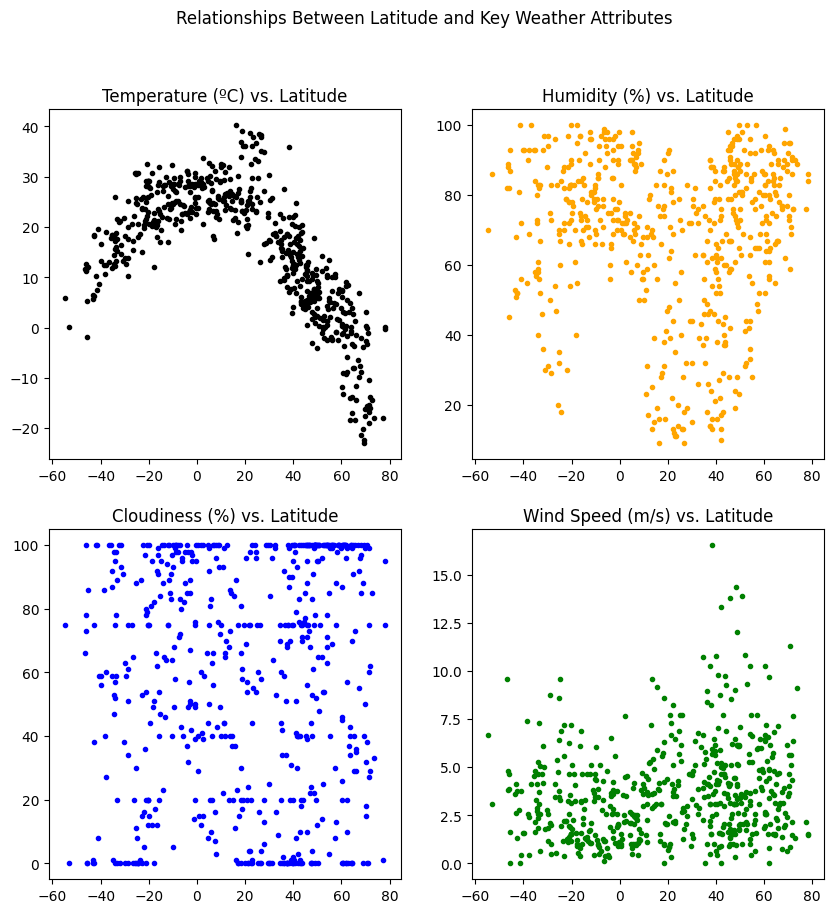

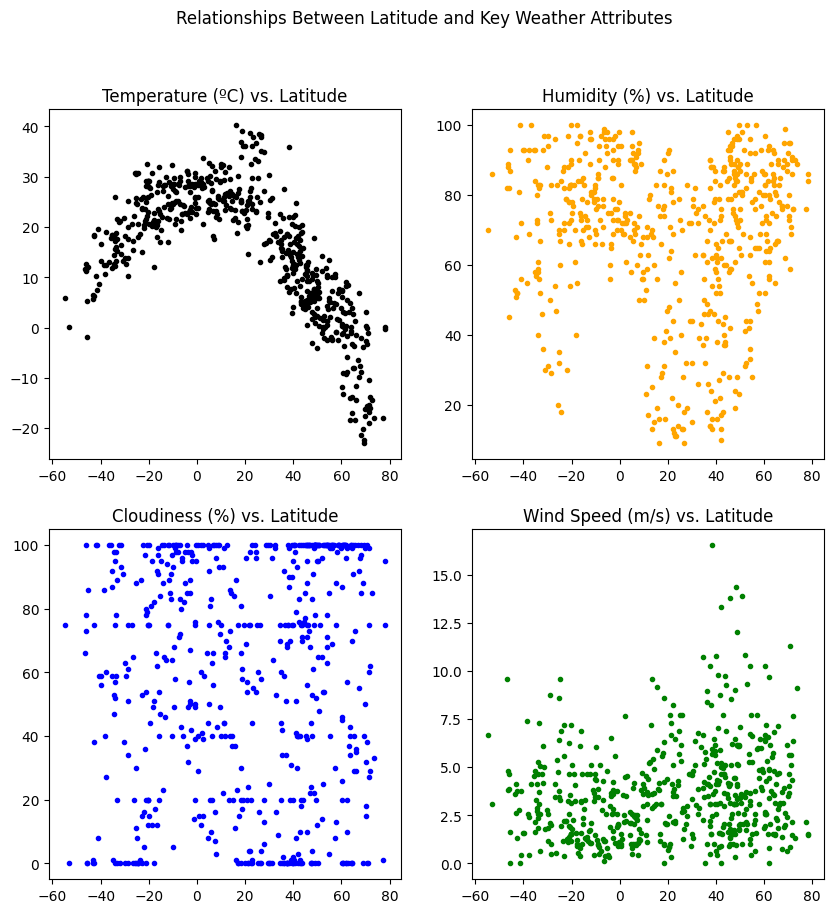

In [8]:
# display a latitude vs. temperature scatter plot
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
fig.suptitle('Relationships Between Latitude and Key Weather Attributes')
axs[0, 0].scatter(city_weather_df['Latitude'], city_weather_df['Temperature (Max)'] - 273.15, c='black', marker='.')
axs[0, 0].set_title('Temperature (ºC) vs. Latitude')
axs[0, 1].scatter(city_weather_df['Latitude'], city_weather_df['Humidity'], c='orange', marker='.')
axs[0, 1].set_title('Humidity (%) vs. Latitude')
axs[1, 0].scatter(city_weather_df['Latitude'], city_weather_df['Cloudiness'], c='blue', marker='.')
axs[1, 0].set_title('Cloudiness (%) vs. Latitude')
axs[1, 1].scatter(city_weather_df['Latitude'], city_weather_df['Wind Speed'], c='green', marker='.')
axs[1, 1].set_title('Wind Speed (m/s) vs. Latitude')

# save and display
fig.savefig("output_data/ScatterPlotFigure.png")
fig

### Apply Linear Regression to Each Relationship

In [9]:
# define a function that splits the data into Northern and Southern hemispheres and computes linear regression
def HemiRegress(lat, att):

    # create a dataframe, then split into Northern and Southern hemispheres
    full_df = pd.DataFrame({'Latitude' : lat, 'Attribute' : att})
    northern_df = full_df.loc[full_df['Latitude'] >= 0]
    southern_df = full_df.loc[full_df['Latitude'] < 0]

    # raise an exception if there is a concern about mismatched data subset sizes
    if len(northern_df) + len(southern_df) != len(full_df):
        raise Exception('Uh oh! Something went wrong splitting your data.')
    
    # perform regressions
    northern_reg = linregress(northern_df['Latitude'], northern_df['Attribute'])
    southern_reg = linregress(southern_df['Latitude'], southern_df['Attribute'])

    # create model arrays for plotting northern hemisphere regression
    northern_x = np.linspace(0, 90, 100)
    northern_y = northern_reg[0] * northern_x + northern_reg[1]

    # create model arrays for plotting southern hemisphere regression
    southern_x = np.linspace(-90, 0, 100)
    southern_y = southern_reg[0] * southern_x + southern_reg[1]

    # create a split plot
    fig, axs = plt.subplots(1, 2, figsize=(13, 5))
    fig.suptitle(f'{att.name} vs. Latitude Split by Hemisphere')

    # draw southern hemisphere plot
    axs[0].scatter(southern_df['Latitude'], southern_df['Attribute'], c='blue', marker='.')
    axs[0].plot(southern_x, southern_y, c='red')
    axs[0].set_title('Southern Hemisphere')
    axs[0].set_ylabel(f'{att.name}')
    axs[0].set_xlabel(f'y = {round(southern_reg[0], 2)}x + {round(southern_reg[1], 2)}\nr = {round(southern_reg[2], 5)}', c='r')

    # draw northern hemisphere plot
    axs[1].scatter(northern_df['Latitude'], northern_df['Attribute'], c='green', marker='.')
    axs[1].plot(northern_x, northern_y, c='red')
    axs[1].set_title('Northern Hemisphere')
    axs[1].set_ylabel(f'{att.name}')
    axs[1].set_xlabel(f'y = {round(northern_reg[0], 2)}x + {round(northern_reg[1], 2)}\nr = {round(northern_reg[2], 5)}', c='r')

    # save and display
    fig.savefig(f'output_data/{att.name}_Regressions.png'.replace(' ', '_'))
    fig

    return

##### Temperature Regression

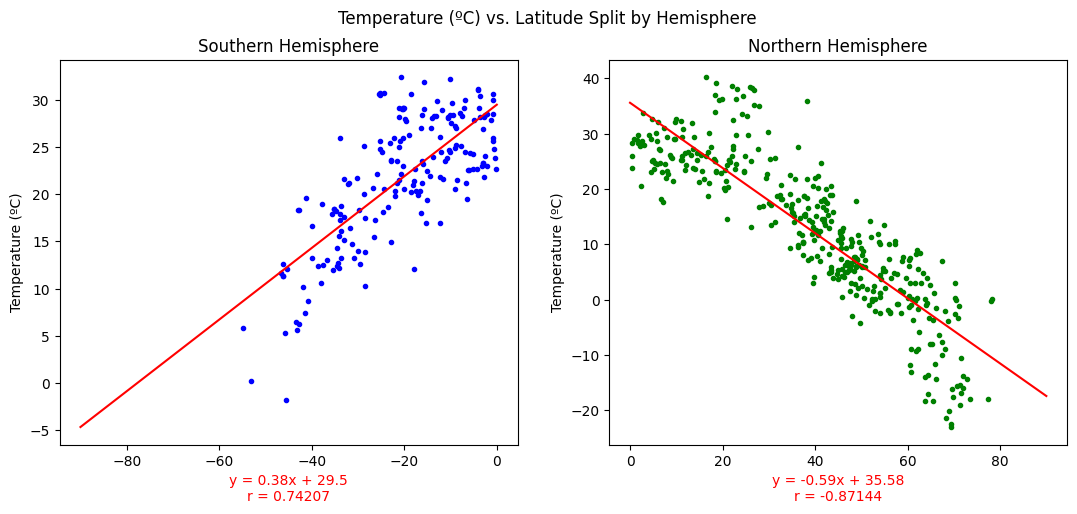

In [10]:
# call our splitting and regression function with the temperature attribute
HemiRegress(city_weather_df['Latitude'], city_weather_df['Temperature (Max)'].rename('Temperature (ºC)') - 273.15)

##### Humidity Regression

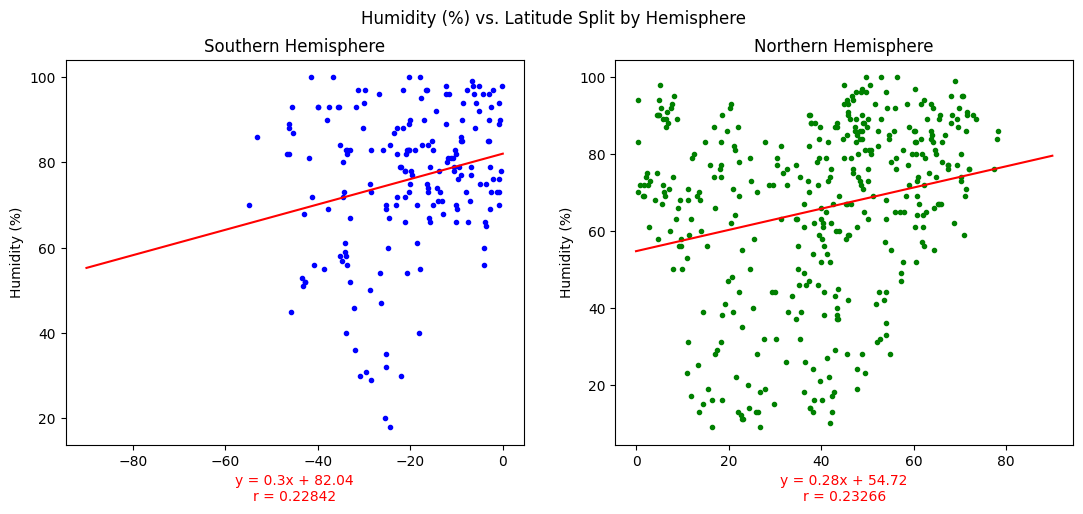

In [11]:
# call our splitting and regression function with the humidity attribute
HemiRegress(city_weather_df['Latitude'], city_weather_df['Humidity'].rename('Humidity (%)'))

##### Cloudiness Regression

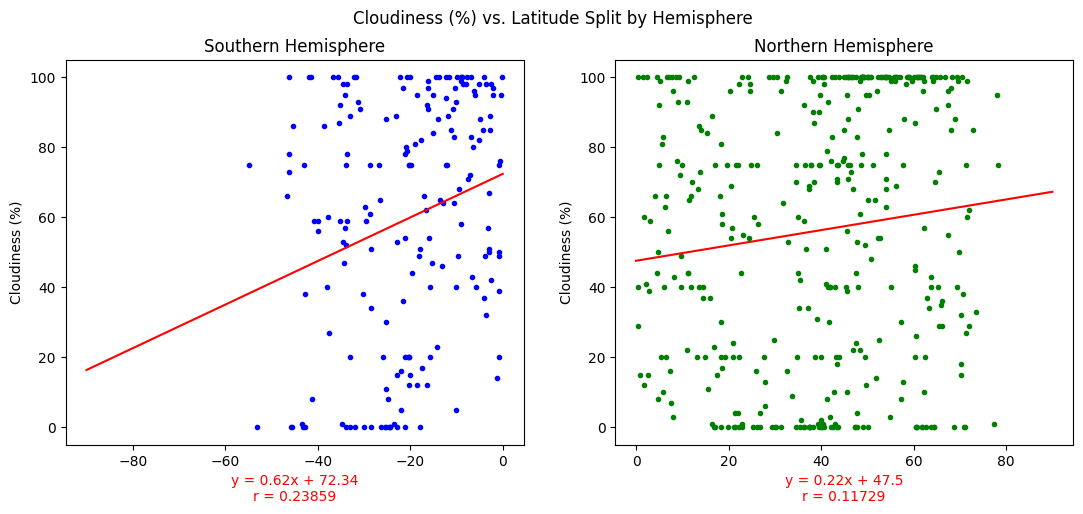

In [12]:
# call our splitting and regression function with the cloudiness attribute
HemiRegress(city_weather_df['Latitude'], city_weather_df['Cloudiness'].rename('Cloudiness (%)'))

##### Wind Speed Regression

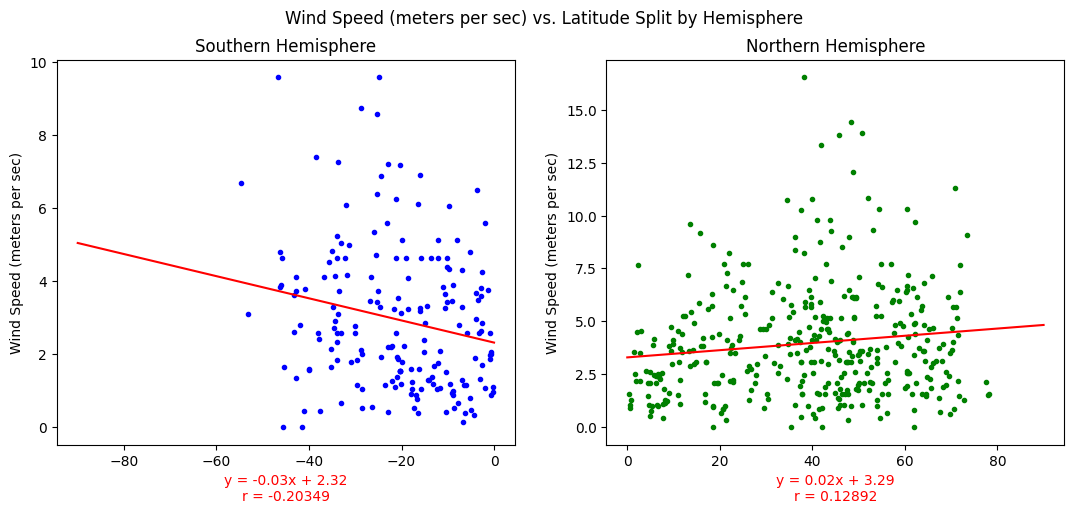

In [13]:
# call our splitting and regression function with the cloudiness attribute
HemiRegress(city_weather_df['Latitude'], city_weather_df['Wind Speed'].rename('Wind Speed (meters per sec)'))